In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.decomposition import FactorAnalysis

In [3]:
# Read in processed data.
df = pd.read_csv('summary_fall2020.csv')
#df = pd.read_csv('summary_fall2020 (ml with max_time = 30).csv')
#df = pd.read_csv('summary_fall2020 (eb with max_time = 120 and min metric = 1).csv') # For some reason this has extra rows.  WTF.

# Somehow, there are two people with raw scores (sums) greater than 75.  This should not be possible.
# I have double checked the Testable version, and it indeed does have the correct questions.

# Transformed values of relevant variables.
df = df.assign(sqrt_eta0 = np.sqrt(df.eta0))
df = df.assign(log_eta0 = np.log(df.eta0))

df_good = df.loc[df.good_perf] # only participants who pass the performance criterion
df_inlab = df_good.loc[df_good.source == 'inlab']
df_online = df_good.loc[df_good.source == 'online']

df_norm = pd.DataFrame(0.0,
                       index = df.index,
                       columns = ['eta0', 'sqrt_eta0', 'log_eta0', 'threat_benign_os', 'promis_anx', 'promis_ang', 'promis_dep',  'promis_pos', 'bite', 'avg_last8_pct_correct'])
for var_name in df_norm.columns.values:
    df_norm[var_name] = (df[var_name] - df[var_name].mean())/df[var_name].std()
df_norm['good_perf'] = df['good_perf']
df_good_norm = df_norm.loc[df_norm.good_perf]
#print(df.head())
print(df.columns)
print(df.shape[0])
print(df_good.shape[0])

Index(['ident', 'schedule', 'age', 'sex', 'latinx', 'race', 'employment',
       'tutorial_0a_last8_pct_correct', 'tutorial_0b_last8_pct_correct',
       'tutorial_0c_last8_pct_correct', 'training_last8_pct_correct',
       'transfer_last8_pct_correct', 'rel_irl', 'threat_benign_os',
       'threat_benign_ri', 'promis_anx_resp1', 'promis_anx_resp2',
       'promis_anx_resp3', 'promis_anx_resp4', 'promis_anx_resp5',
       'promis_anx_resp6', 'promis_anx_resp7', 'promis_anx_resp8',
       'promis_anx_sum', 'promis_anx_std', 'promis_anx', 'promis_ang_resp1',
       'promis_ang_resp2', 'promis_ang_resp3', 'promis_ang_resp4',
       'promis_ang_resp5', 'promis_ang_sum', 'promis_ang_std', 'promis_ang',
       'promis_dep_resp1', 'promis_dep_resp2', 'promis_dep_resp3',
       'promis_dep_resp4', 'promis_dep_resp5', 'promis_dep_resp6',
       'promis_dep_resp7', 'promis_dep_resp8', 'promis_dep_sum',
       'promis_dep_std', 'promis_dep', 'promis_pos_resp1', 'promis_pos_resp2',
       'promis_

histograms


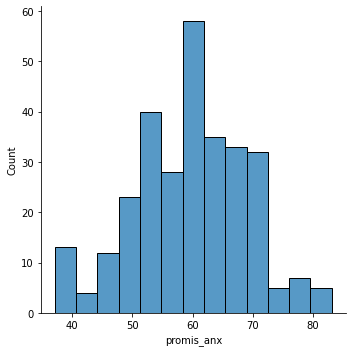

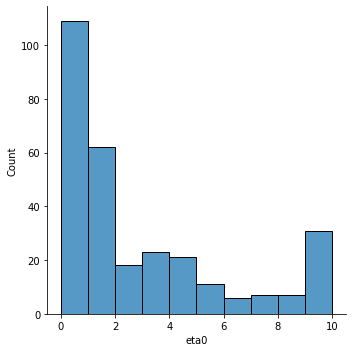

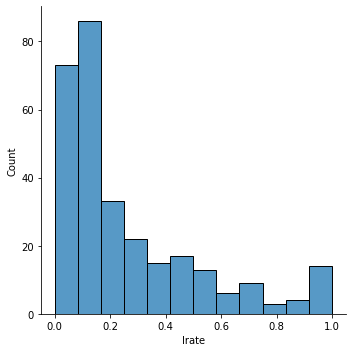

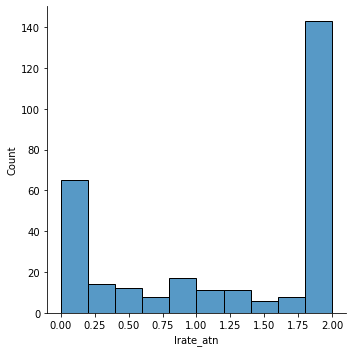

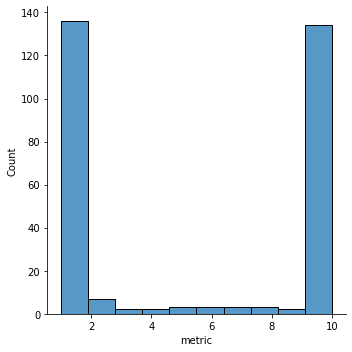

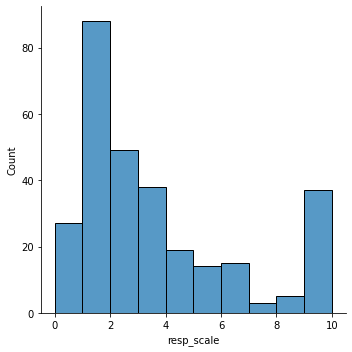

In [4]:
print('histograms')
sns.displot(df['promis_anx'])
sns.displot(df['eta0'])
sns.displot(df['lrate'])
sns.displot(df['lrate_atn'])
sns.displot(df['metric'])
sns.displot(df['resp_scale'])
# FINISH

In [5]:
print('Looking for differences between online and inlab participants:')
ttests = pd.DataFrame(0.0,
                      index = ['training_last8_pct_correct', 'transfer_last8_pct_correct', 'rel_irl', 'threat_benign_os', 'threat_benign_ri', 'eta0'],
                      columns = ['t', 'p', 'mean_online', 'mean_inlab'])
for var_name in ttests.index.values:
    result = stats.ttest_ind(df.loc[df.source == 'online'][var_name], df.loc[df.source == 'inlab'][var_name])
    ttests.loc[var_name]['t'] = np.round(result.statistic, 3)
    ttests.loc[var_name]['p'] = np.round(result.pvalue, 3)
    ttests.loc[var_name]['mean_online'] = np.round(df.loc[df.source == 'online'][var_name].mean(), 3)
    ttests.loc[var_name]['mean_inlab'] = np.round(df.loc[df.source == 'inlab'][var_name].mean(), 3)
print(ttests)
print('It appears that participants in the lab performed better and had a larger rel_irl effect.')

Looking for differences between online and inlab participants:
                                t      p  mean_online  mean_inlab
training_last8_pct_correct -2.942  0.004       72.991      81.004
transfer_last8_pct_correct -3.151  0.002       78.646      86.516
rel_irl                    -3.119  0.002        0.207       0.398
threat_benign_os            0.034  0.973        0.089       0.087
threat_benign_ri           -1.275  0.203       -0.043       0.020
eta0                        0.852  0.395        3.098       2.778
It appears that participants in the lab performed better and had a larger rel_irl effect.


In [6]:
ttests = pd.DataFrame(0.0,
                      index = ['rel_irl', 'threat_benign_os', 'threat_benign_ri', 'eta0'],
                      columns = ['t', 'p', 'effect_size'])
n = df.shape[0]
for var_name in ttests.index.values:
    if var_name == 'eta0':
        popmean = 1
    else:
        popmean = 0
    result = stats.ttest_1samp(df[var_name], popmean)
    ttests.loc[var_name]['t'] = np.round(result.statistic, 3)
    ttests.loc[var_name]['p'] = np.round(result.pvalue, 3)
    ttests.loc[var_name]['effect_size'] = np.round(result.statistic/np.sqrt(n), 3)

print('t tests for OAT scores and salience parameter (eta0):')
print('df = ' + str(n - 1))
print(ttests)
print()
print('For comparison, here are the spring 2020 results:')
# I SHOULD DOUBLE CHECK THAT THE OAT SCORES WERE COMPUTED THE SAME WAY BACK IN THE SPRING.
# I SHOULD ALSO LOOK UP THE rel_irl RESULTS
# ALSO, THE VALUES IN THE HTML OUTPUT ARE FROM AN EARLIER ANALYSIS THAT DIDN'T HAVE ALL PARTICIPANTS YET.
ttests_spring = pd.DataFrame(0.0,
                      index = ['threat_benign_os', 'threat_benign_ri', 'eta0'],
                      columns = ['t', 'p', 'effect_size'])
ttests_spring.loc['threat_benign_os'] = [2.276, 0.024, 0.195] # called index_sal
ttests_spring.loc['threat_benign_ri'] = [1.061, 0.290, 0.091] # called index_sal_rel
ttests_spring.loc['eta0'] = [6.772, 0.000, 0.581] # this was df_s20$eta0t_ml, i.e. the maximum likelihood estimate (not exactly comparable)
print('df = 135')
print(ttests_spring)

t tests for OAT scores and salience parameter (eta0):
df = 294
                       t      p  effect_size
rel_irl            9.403  0.000        0.547
threat_benign_os   2.279  0.023        0.133
threat_benign_ri  -0.659  0.510       -0.038
eta0              10.541  0.000        0.614

For comparison, here are the spring 2020 results:
df = 135
                      t      p  effect_size
threat_benign_os  2.276  0.024        0.195
threat_benign_ri  1.061  0.290        0.091
eta0              6.772  0.000        0.581


In [14]:
print('proportion of participants who met performance criterion:')
# The spring data only include people without any missing data (several were missing OAT scores).
perf_summary = pd.DataFrame(index = ['spring', 'fall_total', 'fall_inlab', 'fall_online'],
                            columns = ['total', 'good', 'pct_good'])
perf_summary.loc['spring']['total'] = 153
perf_summary.loc['spring']['good'] = 106
perf_summary.loc['spring']['pct_good'] = 100*106/153
perf_summary.loc['fall_total']['total'] = df.shape[0]
perf_summary.loc['fall_total']['good'] = df['good_perf'].sum()
perf_summary.loc['fall_total']['pct_good'] = 100*df['good_perf'].sum()/df.shape[0]
perf_summary.loc['fall_inlab']['total'] = df.loc[df.source == 'inlab'].shape[0]
perf_summary.loc['fall_inlab']['good'] = df.loc[df.source == 'inlab']['good_perf'].sum()
perf_summary.loc['fall_inlab']['pct_good'] = 100*df.loc[df.source == 'inlab']['good_perf'].sum()/df.loc[df.source == 'inlab'].shape[0]
perf_summary.loc['fall_online']['total'] = df.loc[df.source == 'online'].shape[0]
perf_summary.loc['fall_online']['good'] = df.loc[df.source == 'online']['good_perf'].sum()
perf_summary.loc['fall_online']['pct_good'] = 100*df.loc[df.source == 'online']['good_perf'].sum()/df.loc[df.source == 'online'].shape[0]
print(perf_summary)

proportion of participants who met performance criterion:
            total good pct_good
spring        153  106   69.281
fall_total    295  168  56.9492
fall_inlab    127   88  69.2913
fall_online   168   80   47.619


In [15]:
print('correlations with salience measures (OAT score and eta0) \n')
# Including confidence ratings (for the in lab data) REDUCES the threat_benign_os correlation.
print(stats.pearsonr(df_good['promis_anx'], df_good['threat_benign_os']))
print(stats.pearsonr(df_inlab['promis_anx'], df_inlab['threat_benign_os']))
print(stats.pearsonr(df_online['promis_anx'], df_online['threat_benign_os']))
print()
print(stats.pearsonr(df_good['promis_anx'], df_good['eta0']))
print(stats.pearsonr(df_inlab['promis_anx'], df_inlab['eta0']))
print(stats.pearsonr(df_online['promis_anx'], df_online['eta0']))

correlations with salience measures (OAT score and eta0) 

(-0.15368061811106784, 0.04671360284332743)
(-0.1573710361125235, 0.14311086711049514)
(-0.15160586495429185, 0.17945444491642173)

(-0.006850141963592328, 0.9297764347826317)
(-0.01571865404365686, 0.8844308549554917)
(-0.003189569664289349, 0.9775987856318252)


In [16]:
model = smf.ols(formula = 'threat_benign_os ~ promis_anx*avg_last8_pct_correct',
                data = df_norm)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       threat_benign_os   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.722
Date:                Wed, 13 Jan 2021   Prob (F-statistic):              0.163
Time:                        08:51:28   Log-Likelihood:                -415.49
No. Observations:                 295   AIC:                             839.0
Df Residuals:                     291   BIC:                             853.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

[1.393 0.23  5.   ]
                            OLS Regression Results                            
Dep. Variable:       threat_benign_os   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.393
Date:                Wed, 13 Jan 2021   Prob (F-statistic):              0.230
Time:                        08:51:52   Log-Likelihood:                -240.73
No. Observations:                 168   AIC:                             493.5
Df Residuals:                     162   BIC:                             512.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0079      0.080

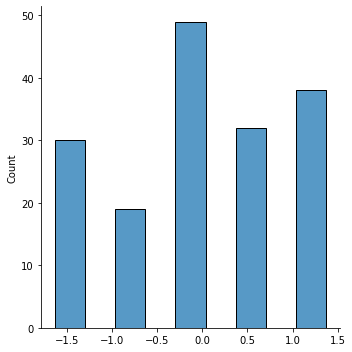

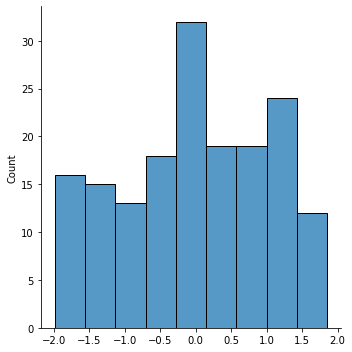

In [17]:
# SALIENCE OAT SCORE (threat_benign_os)
data = df_good_norm
model0 = smf.ols(formula = 'threat_benign_os ~ 1',
                 data = data)
model1 = smf.ols(formula = 'threat_benign_os ~ promis_anx + promis_ang + promis_dep + promis_pos + bite',
                 data = data)
result0 = model0.fit()
result1 = model1.fit()
# I should determine if the whole model (considering all of the psych measures together) is predictive.
print(np.round(result1.compare_f_test(result0), 3))
print(result1.summary())
#sns.relplot(x = 'promis_anx', y = 'threat_benign_os', data = df_norm)
sns.displot(result0.resid)
sns.displot(result1.resid)

[0.167 0.919 3.   ]
                            OLS Regression Results                            
Dep. Variable:              sqrt_eta0   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.1665
Date:                Wed, 13 Jan 2021   Prob (F-statistic):              0.919
Time:                        09:28:03   Log-Likelihood:                -187.36
No. Observations:                 168   AIC:                             382.7
Df Residuals:                     164   BIC:                             395.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

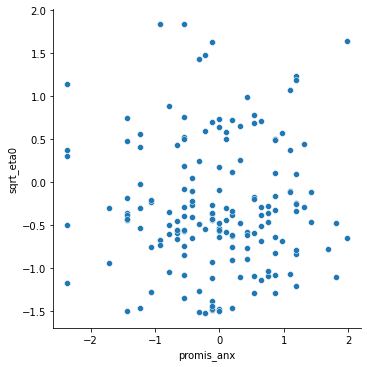

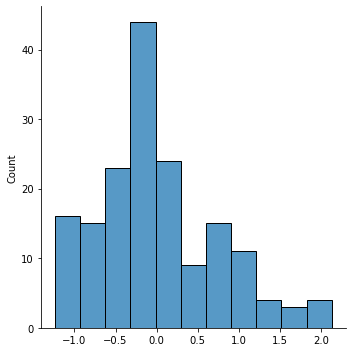

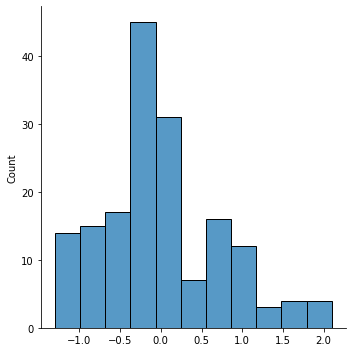

In [20]:
# MODEL SALIENCE PARAMETER (eta0)
data = df_good_norm
y = 'sqrt_eta0'
model0 = smf.ols(formula = y + ' ~ 1',
                 data = data)
model1 = smf.ols(formula = y + ' ~ promis_anx + promis_ang + promis_dep + promis_pos + bite',
                 data = data)
result0 = model0.fit()
result1 = model1.fit()
# I should determine if the whole model (considering all of the psych measures together) is predictive.
print(np.round(result1.compare_f_test(result0), 3))
print(result1.summary())

#https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
#https://www.statsmodels.org/stable/examples/notebooks/generated/regression_diagnostics.html
infl = result1.get_influence()
print(2/np.sqrt(data.shape[0]))
print(np.abs(infl.summary_frame().filter(regex="dfb")).max())

sns.relplot(x = 'promis_anx', y = y, data = data)
sns.displot(result0.resid)
sns.displot(result1.resid)

In [ ]:
# UPDATE EVERYTHING BELOW

In [ ]:
print('Demographic Breakdown (In Lab) \n')

print(summary_fall2020_inlab['sex'].value_counts())
print('\n')
print(summary_fall2020_inlab['latinx'].value_counts())
print('\n')
print(summary_fall2020_inlab['race'].value_counts())

In [ ]:
print('Demographic Breakdown (Online) \n')

print(summary_fall2020_online['sex'].value_counts())
print('\n')
print(summary_fall2020_online['latinx'].value_counts())
print('\n')
print(summary_fall2020_online['race'].value_counts())

In [ ]:
print('Raw Behavioral Scores (In Lab) \n')

score_name = ['rel_irl', 'threat_benign_os', 'threat_benign_ri']
n_score = len(score_name)
mean = np.zeros(n_score)
t_val = np.zeros(n_score)
p_val = np.zeros(n_score)
for i in range(n_score):
    mean[i] = np.round(summary_fall2020_inlab[score_name[i]].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_inlab[score_name[i]], popmean = 0), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
behav_scores_tests = pd.DataFrame({'score_name': score_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(behav_scores_tests)

In [ ]:
print('Raw Behavioral Scores (Online) \n')

score_name = ['rel_irl', 'threat_benign_os', 'threat_benign_ri']
n_score = len(score_name)
mean = np.zeros(n_score)
t_val = np.zeros(n_score)
p_val = np.zeros(n_score)
for i in range(n_score):
    mean[i] = np.round(summary_fall2020_online[score_name[i]].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_online[score_name[i]], popmean = 0), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
behav_scores_tests = pd.DataFrame({'score_name': score_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(behav_scores_tests)

In [ ]:
print('Percent Correct per Stage (In Lab) \n')

stage_name = ['tutorial_0a', 'tutorial_0b', 'tutorial_0c', 'training', 'transfer']
n_stage = len(stage_name)
mean = np.zeros(n_stage)
t_val = np.zeros(n_stage)
p_val = np.zeros(n_stage)
for i in range(n_stage):
    mean[i] = np.round(summary_fall2020_inlab[stage_name[i] + '_pct_correct'].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_inlab[stage_name[i] + '_pct_correct'], popmean = 50), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
pct_correct_tests = pd.DataFrame({'stage_name': stage_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(pct_correct_tests)

In [ ]:
print('Percent Correct per Stage (Online) \n')

stage_name = ['tutorial_0a', 'tutorial_0b', 'tutorial_0c', 'training', 'transfer']
n_stage = len(stage_name)
mean = np.zeros(n_stage)
t_val = np.zeros(n_stage)
p_val = np.zeros(n_stage)
for i in range(n_stage):
    mean[i] = np.round(summary_fall2020_online[stage_name[i] + '_pct_correct'].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_online[stage_name[i] + '_pct_correct'], popmean = 50), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
pct_correct_tests = pd.DataFrame({'stage_name': stage_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(pct_correct_tests)

In [ ]:
sns.displot(summary_fall2020_online[stage_name[0] + '_pct_correct'])

In [ ]:
print(np.round(stats.ttest_1samp(df['eta0'], popmean = 1), 4))
print(np.round(stats.ttest_1samp(df['threat_benign_os'], popmean = 0), 4))
d = df['threat_benign_os'].mean()/df['threat_benign_os'].std()
print(d)